# NUOPC versus MCT validation (G-compset)

Gustavo Marques & Mariana Vertenstein

March 26th 2021

**Instructions from Mariana:**

CESM branch

```
git clone https://github.com/ESCOMP/CESM.git
cd CESM
git checkout nuopc_dev.validation
./manage_externals/checkout_externals  -v
cd cime
git checkout mvertens/compare_to_nuopc
```

Changes in MCT

```Set COMPARE_TO_NUOPC=True```

Sends snapshots of ocn fields during the first time step (rather than avgs). 

Changes in NUOPC/CMEPS

* Use mapbilnr for u and v
* import_swpen_by_bands = .false.


* Incorporated flux correction factors into nuopc cap

https://github.com/NCAR/MOM6/pull/176


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mom6_tools.m6plot import xycompare
from mom6_tools.MOM6grid import MOM6grid
import warnings
warnings.filterwarnings('ignore')

Basemap module not found. Some regional plots may not function properly


In [2]:
pth = '/glade/scratch/gmarques/'
grd = MOM6grid(pth+'gmom.e22.GNYF.T62_t061_zstar.mct_validation/run/ocean.mom6.static.nc')

MOM6 grid successfully loaded... 



### MCT 

In [3]:
mom_mct1 = xr.open_dataset(pth+"gmom.e22.GNYF.T62_t061_zstar.mct_validation_default.002/run/ocean.mom6.snap_0001.nc")
cpl_mct1 = xr.open_mfdataset(pth+"gmom.e22.GNYF.T62_t061_zstar.mct_validation_default.002/run/*.cpl.hi*.nc")

### NUOPC 

In [4]:
# 1) default online mapping files
mom_nuopc1 = xr.open_dataset(pth+"gmom.e22.GNYF.T62_t061_zstar.nuopc_validation_default.001/run/ocean.mom6.snap_0001.nc")
cpl_nuopc1 = xr.open_mfdataset(pth+"gmom.e22.GNYF.T62_t061_zstar.nuopc_validation_default.001/run/*.cpl.hi*.nc")

### CPL variables to be compared

In [5]:
pairs_export = [
("ocnExp_Faxa_rain", "x2oacc_Faxa_rain"),
("ocnExp_Faxa_snow", "x2oacc_Faxa_snow"),
("ocnExp_Fioi_melth", "x2oacc_Fioi_melth"),
("ocnExp_Fioi_meltw", "x2oacc_Fioi_meltw"),
("ocnExp_Fioi_salt", "x2oacc_Fioi_salt"),
("ocnExp_Foxx_evap", "x2oacc_Foxx_evap"),
("ocnExp_Foxx_rofi", "x2oacc_Foxx_rofi"),
("ocnExp_Foxx_rofl", "x2oacc_Foxx_rofl"),
("ocnExp_Foxx_sen", "x2oacc_Foxx_sen"),   
("ocnExp_Foxx_taux", "x2oacc_Foxx_taux"),
("ocnExp_Foxx_tauy", "x2oacc_Foxx_tauy"),
("ocnExp_Sa_pslv", "x2oacc_Sa_pslv"),
("iceExp_Sa_v", "x2i_Sa_v"),
("iceExp_Sa_u", "x2i_Sa_u"),
("iceExp_Sa_z","x2i_Sa_z"),
("iceExp_So_s","x2i_So_s"),

]    


In [7]:
pairs_import = [
("iceImp_Si_ifrac", "i2x_Si_ifrac"),
("ocnImp_So_s", "o2x_So_s"),
("ocnImp_So_t", "o2x_So_t"),
("ocnImp_So_u", "o2x_So_u"),
("ocnImp_So_v", "o2x_So_v"),
("ocnImp_So_dhdx", "o2x_So_dhdx"),
("ocnImp_So_dhdy", "o2x_So_dhdy"),
("ocnImp_So_bldepth", "o2x_So_bldepth"),
("ocnImp_Fioo_q", "o2x_Fioo_q")
]

### MOM6 variables to compare

In [8]:
variables = ['taux', 'tauy', 'latent', 'sensible', 'SW', 'LW', 'salt_flux_in', 'seaice_melt', 'evap', 
            'lrunoff', 'frunoff', 'lprec', 'fprec','net_heat_coupler','evap',
             'seaice_melt_heat','salt_flux_in']

## 1) Compare MCT vs NUOPC out-of-the-box

### Export

MCT time (days) =  0001-01-01 02:00:00
NUOPC time (days) =  0001-01-01 02:00:00


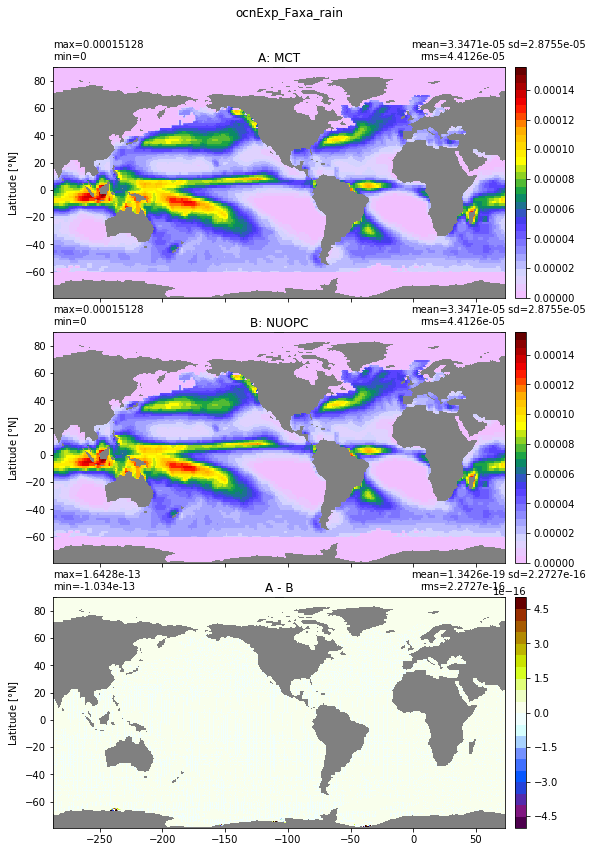

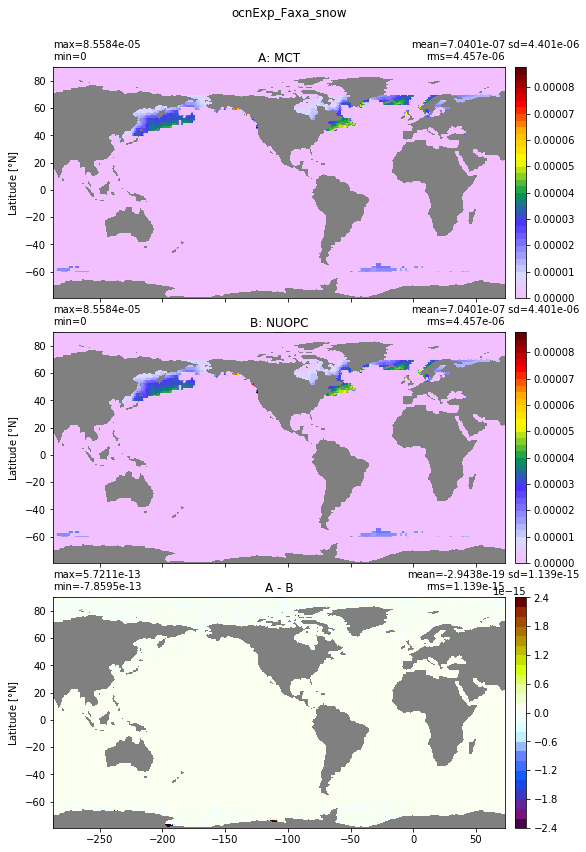

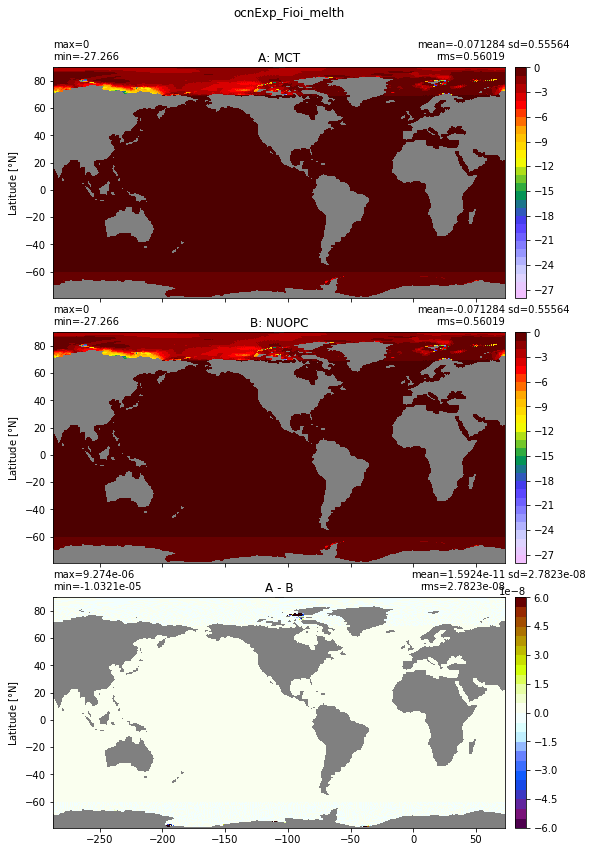

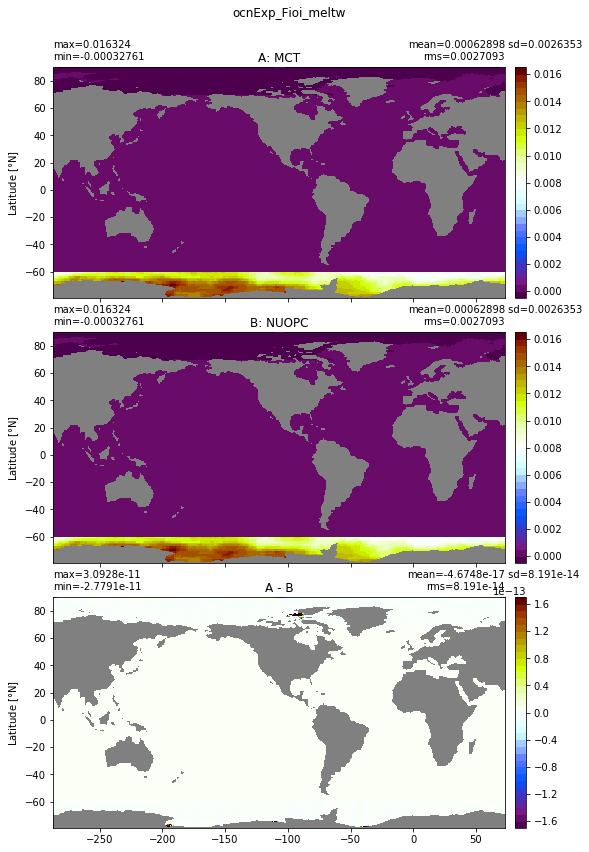

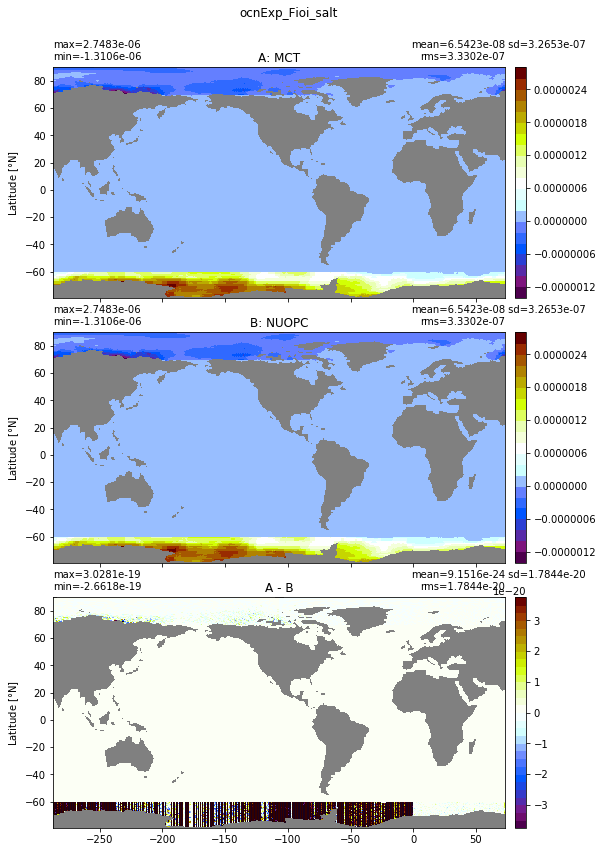

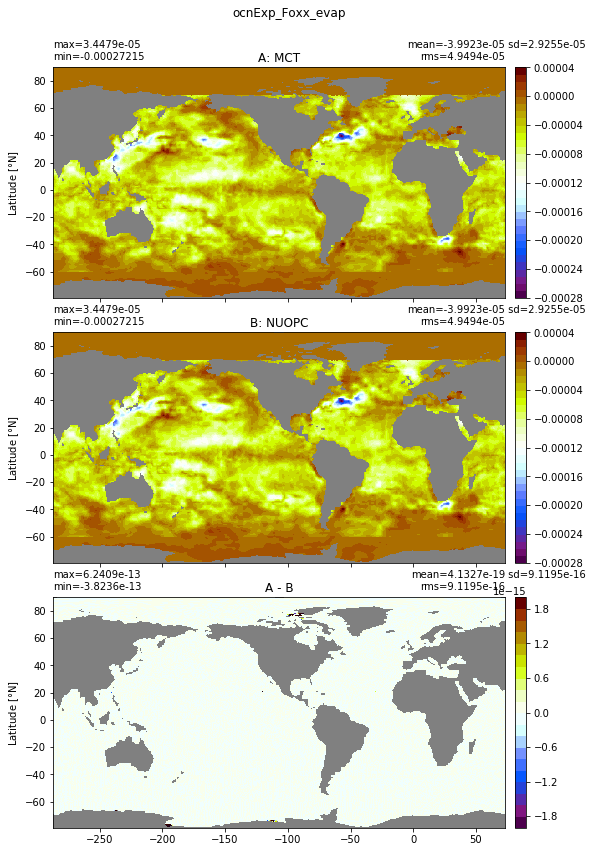

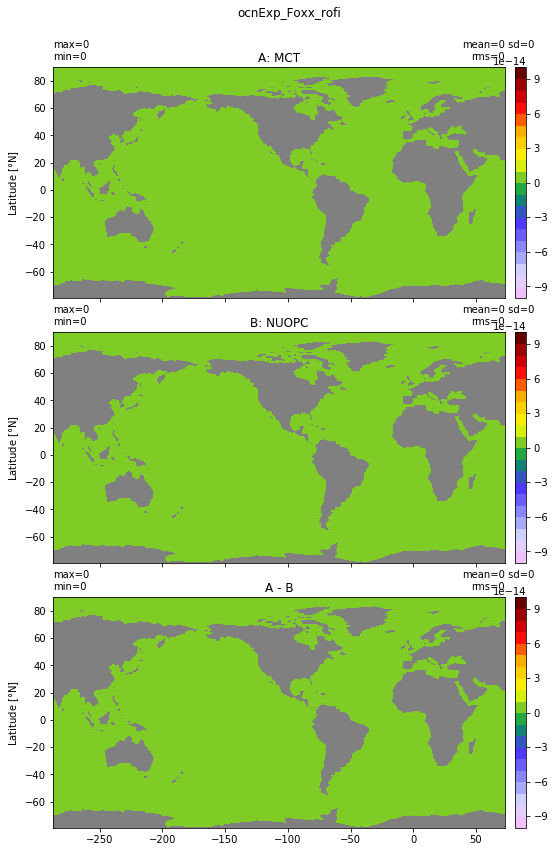

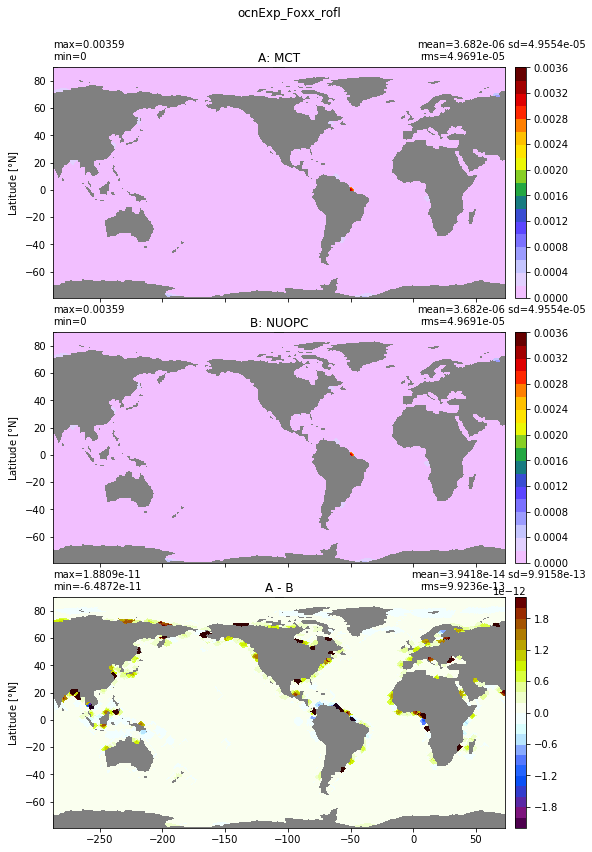

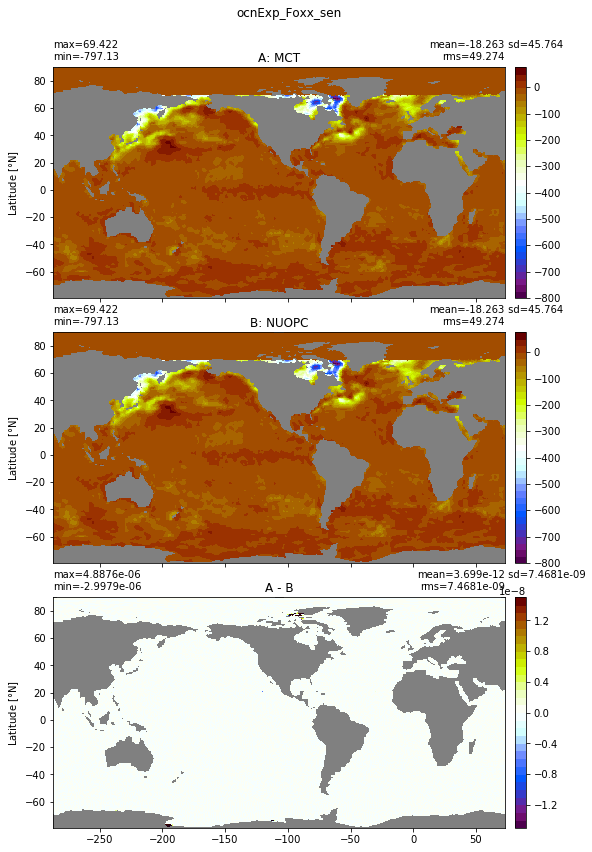

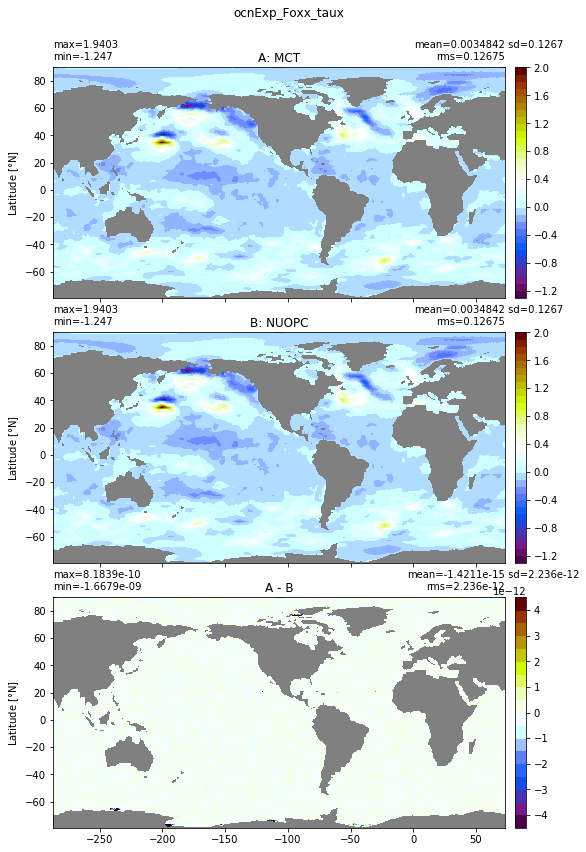

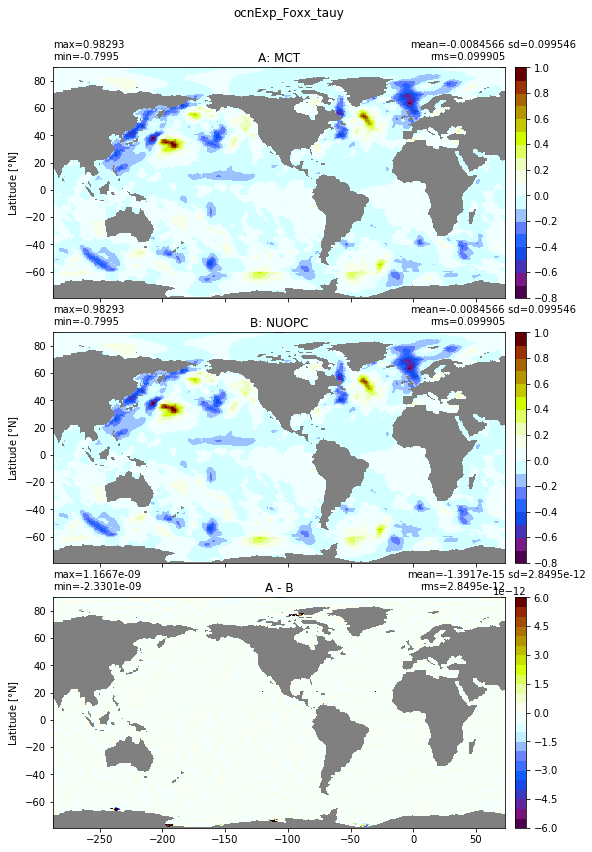

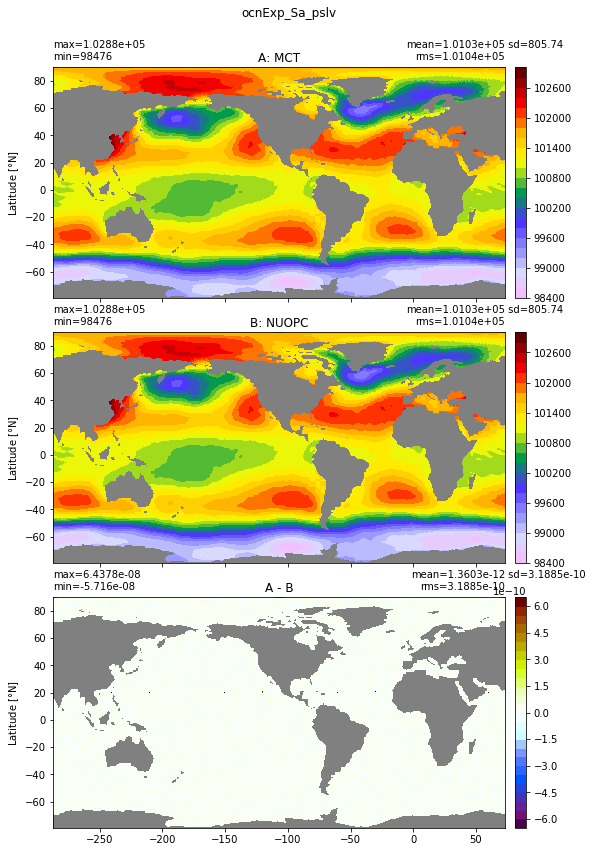

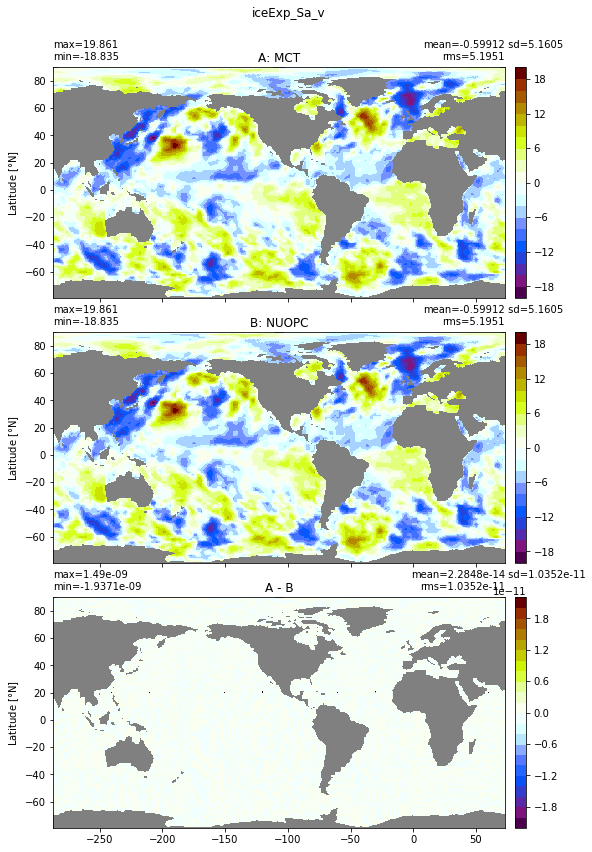

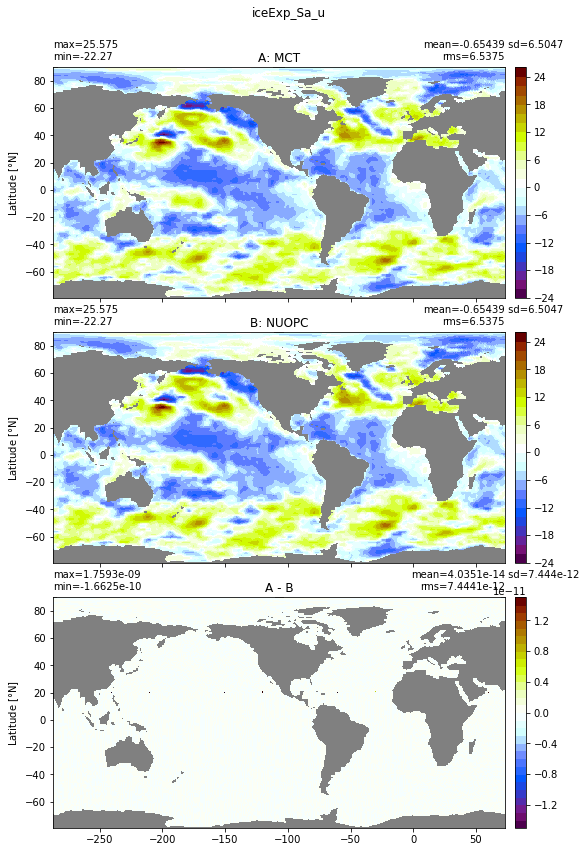

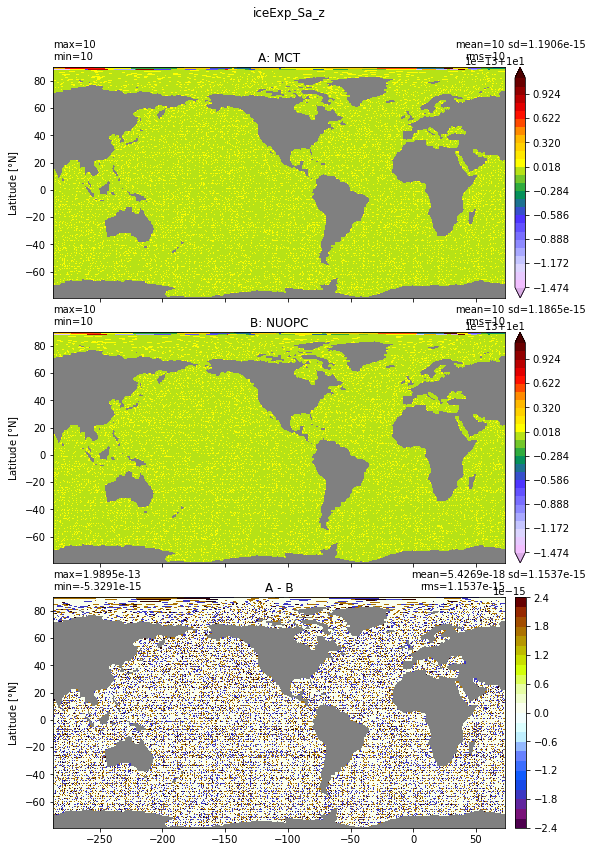

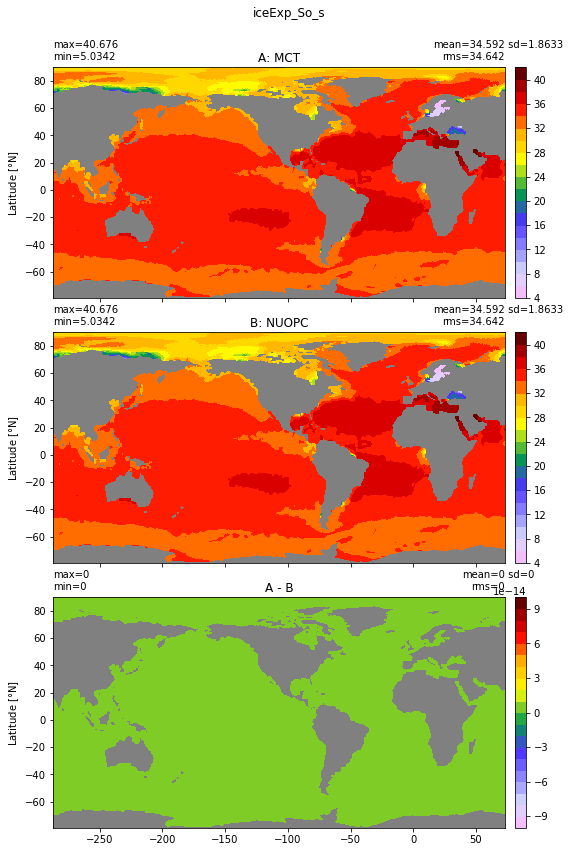

In [9]:
%matplotlib inline

t = 1 # time indice
print('MCT time (days) = ',cpl_mct1['time'][t].values)
print('NUOPC time (days) = ',cpl_nuopc1['time'][t].values)

for p in range(len(pairs_export)):
    #print(pairs[p])
    mct_var = np.ma.masked_invalid(cpl_mct1[pairs_export[p][1]][t,:].values)#* grd.wet
    nuopc_var = np.ma.masked_invalid(cpl_nuopc1[pairs_export[p][0]][t,:].values)#* grd.wet
    mct_var = np.ma.masked_where(grd.wet == 0., mct_var)
    nuopc_var = np.ma.masked_where(grd.wet == 0., nuopc_var)
    xycompare(mct_var, nuopc_var, x=grd.geolon, y=grd.geolat, area=grd.area_t, title1='MCT', title2='NUOPC', suptitle=pairs_export[p][0])
   

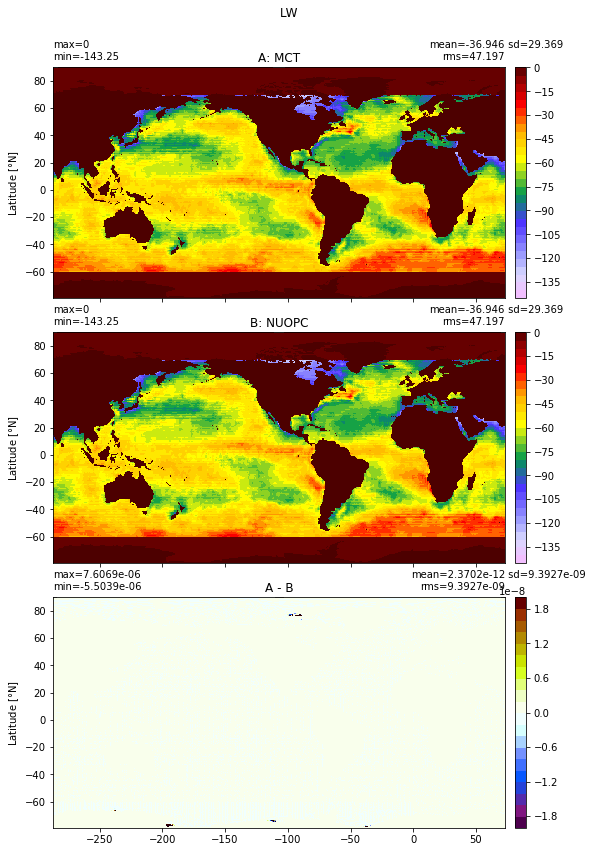

In [30]:
# long wave
lw_nuopc = np.ma.masked_invalid(cpl_nuopc1['ocnExp_Foxx_lwnet'][t,:].values)* grd.wet
dummy = cpl_mct1['x2oacc_Faxa_lwdn'][t,:].values + cpl_mct1['x2oacc_Foxx_lwup'][t,:].values
lw_mct = np.ma.masked_invalid(dummy)* grd.wet
xycompare(lw_mct,lw_nuopc, x=grd.geolon, y=grd.geolat, area=grd.area_t, title1='MCT', title2='NUOPC', suptitle='LW')

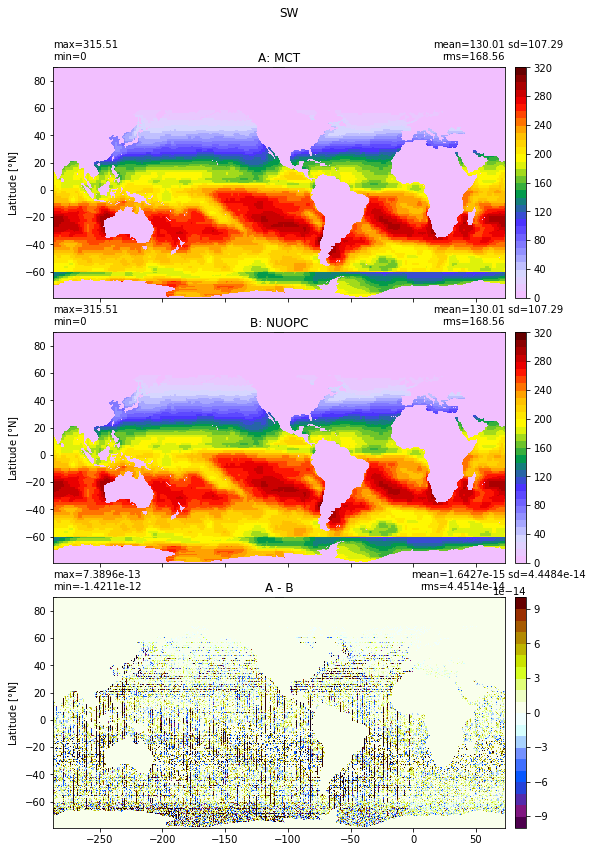

In [33]:
# short wave
dummy =  cpl_nuopc1['ocnExp_Foxx_swnet_idf'][t,:] + \
         cpl_nuopc1['ocnExp_Foxx_swnet_idr'][t,:] + \
         cpl_nuopc1['ocnExp_Foxx_swnet_vdf'][t,:] + \
         cpl_nuopc1['ocnExp_Foxx_swnet_vdr'][t,:]

sw_nuopc = np.ma.masked_invalid(dummy.values)
sw_mct = np.ma.masked_invalid(cpl_mct1['x2oacc_Foxx_swnet'][t,:].values)* grd.wet
xycompare(sw_mct, sw_nuopc, x=grd.geolon, y=grd.geolat, area=grd.area_t, title1='MCT', title2='NUOPC', suptitle='SW')

### Imports

MCT time (days) =  0001-01-01 02:00:00
NUOPC time (days) =  0001-01-01 02:00:00


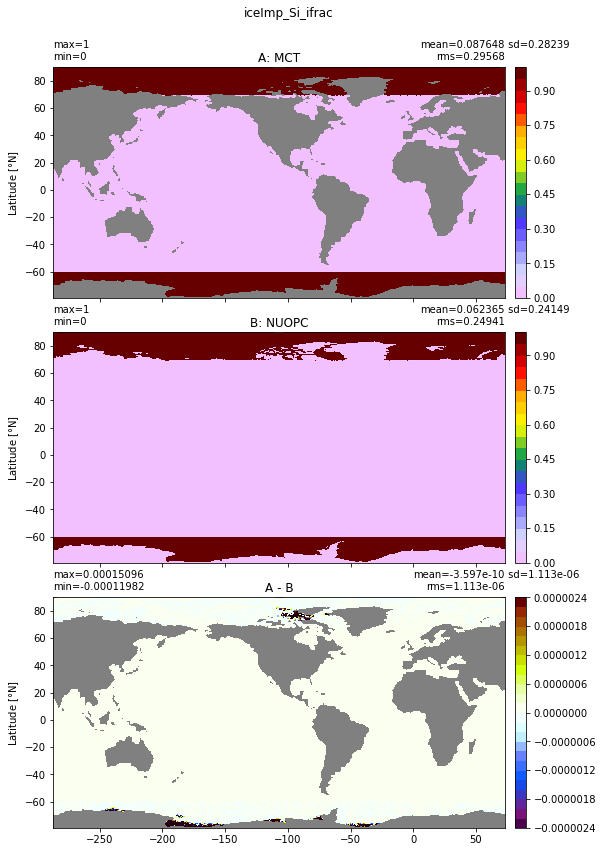

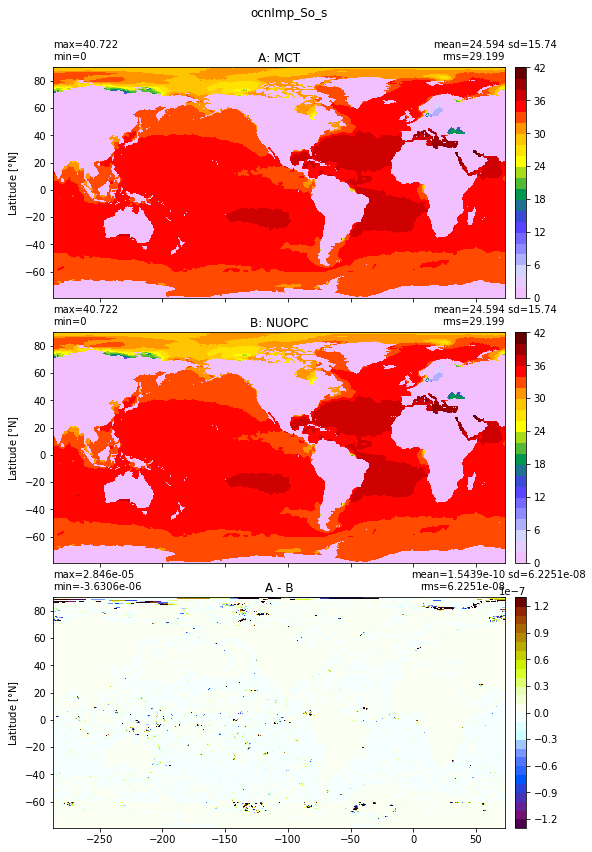

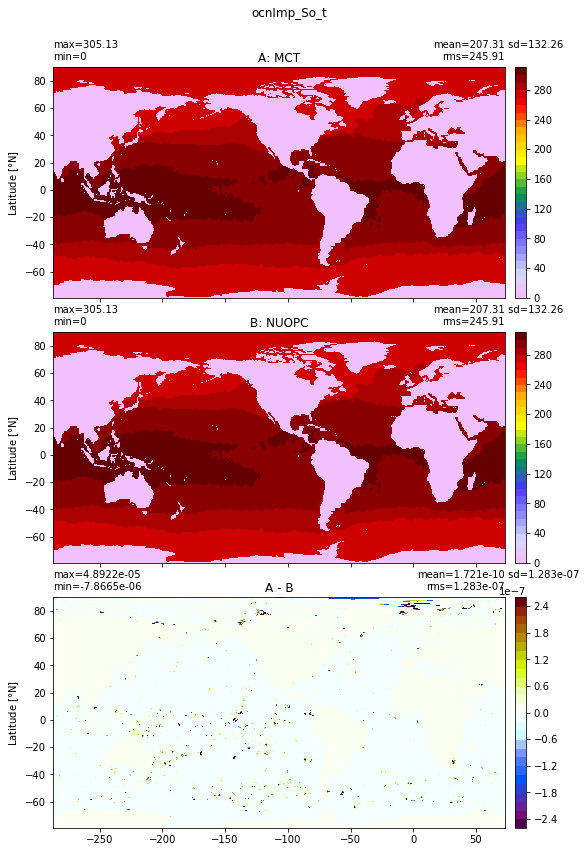

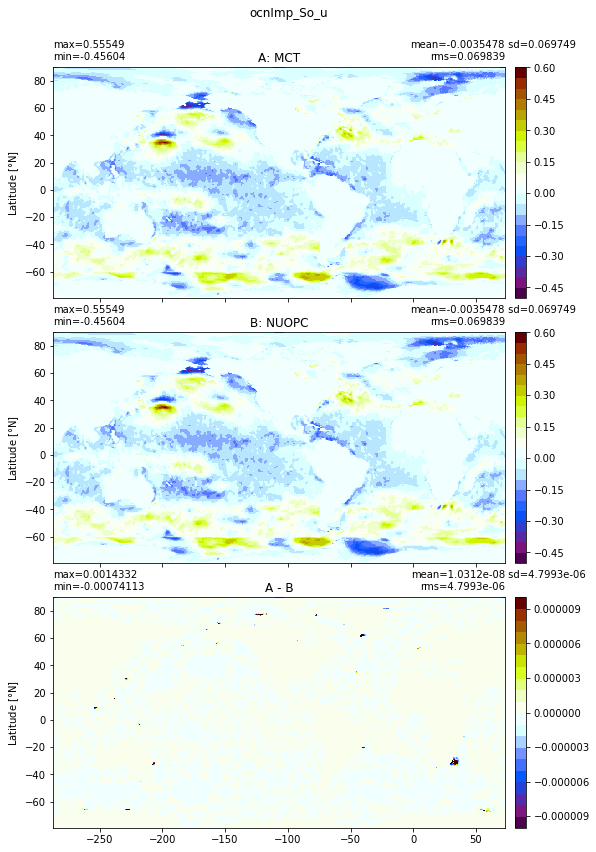

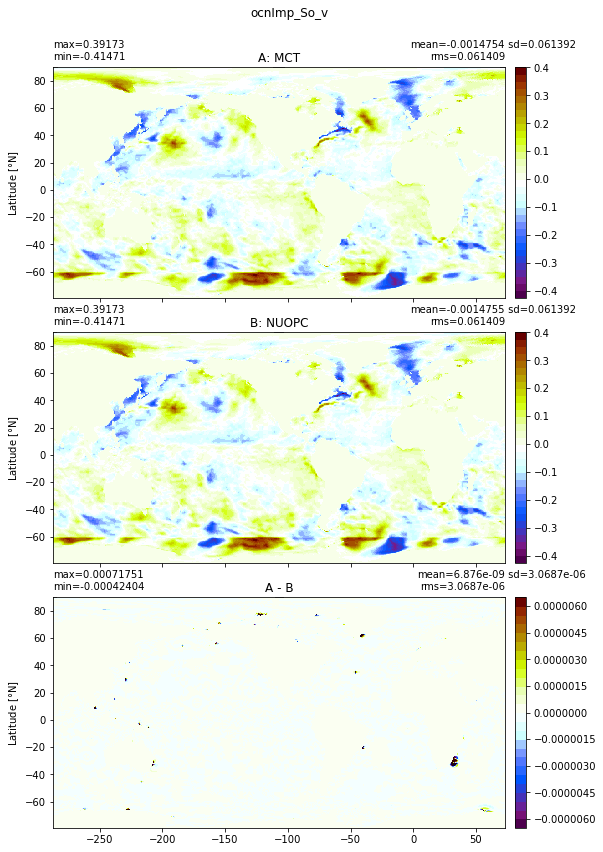

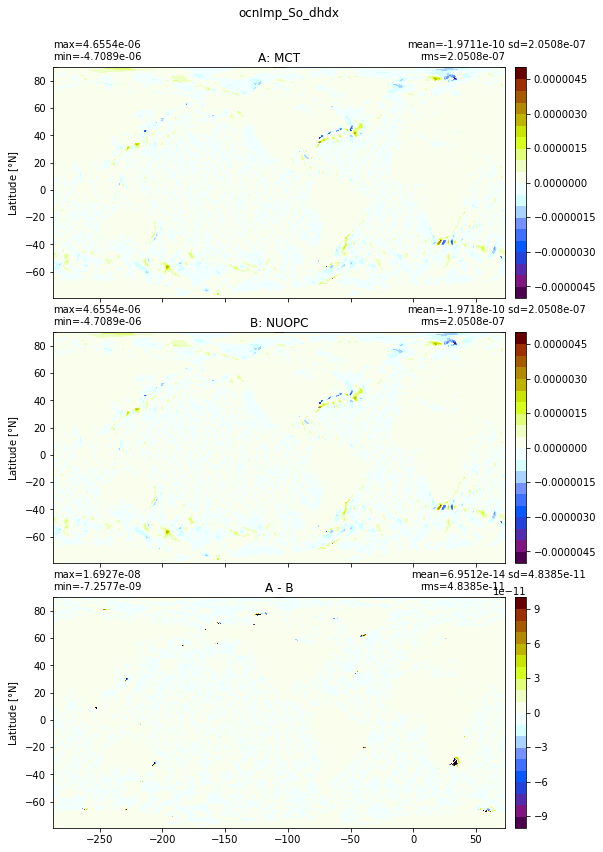

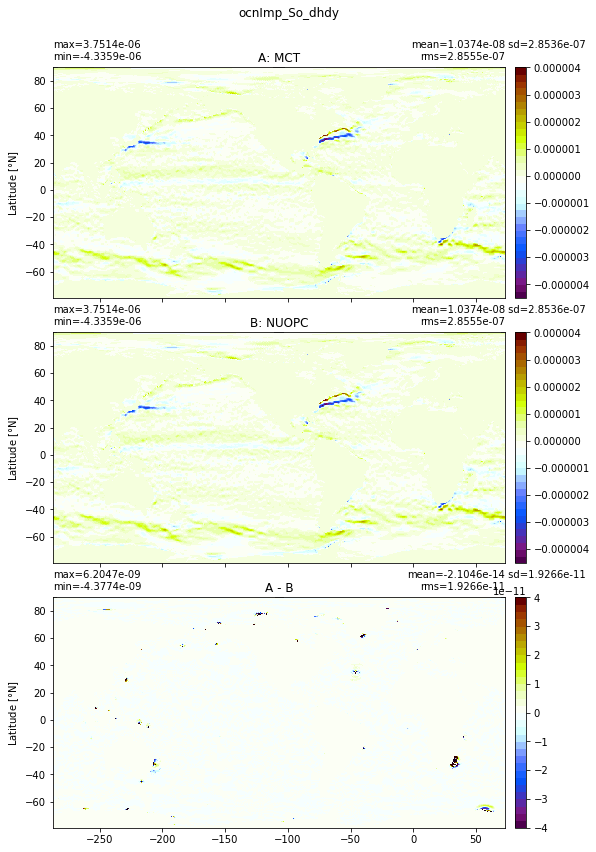

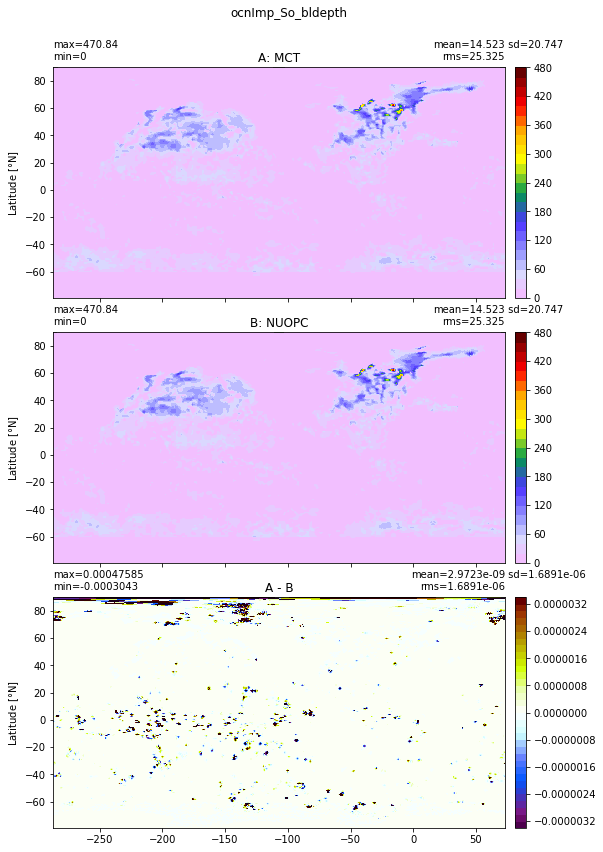

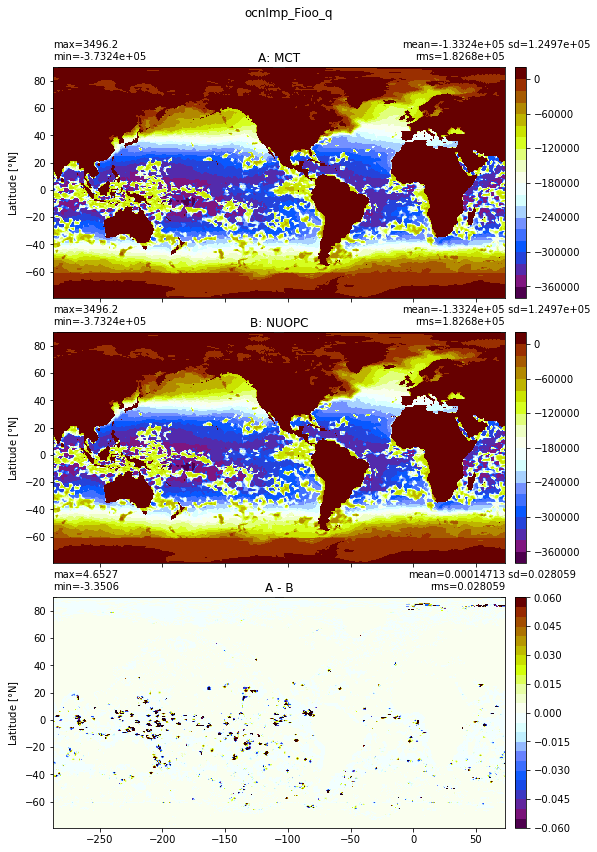

In [10]:
%matplotlib inline

t = 1 # time indice
print('MCT time (days) = ',cpl_mct1['time'][t].values)
print('NUOPC time (days) = ',cpl_nuopc1['time'][t].values)

for p in range(len(pairs_import)):
    #print(pairs[p])
    mct_var = np.ma.masked_invalid(cpl_mct1[pairs_import[p][1]][t,:].values)* grd.wet
    nuopc_var = np.ma.masked_invalid(cpl_nuopc1[pairs_import[p][0]][t,:].values)* grd.wet
    xycompare(mct_var, nuopc_var, x=grd.geolon, y=grd.geolat, area=grd.area_t, title1='MCT', title2='NUOPC', suptitle=pairs_import[p][0])
   

## MOM6 output

MCT time (days) =  0001-01-01 02:00:00
NUOPC time (days) =  0001-01-01 02:00:00


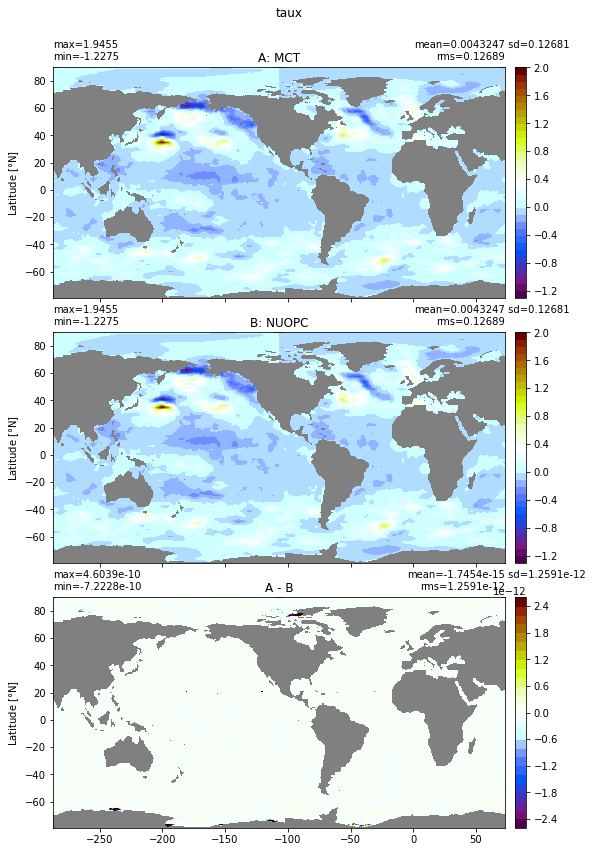

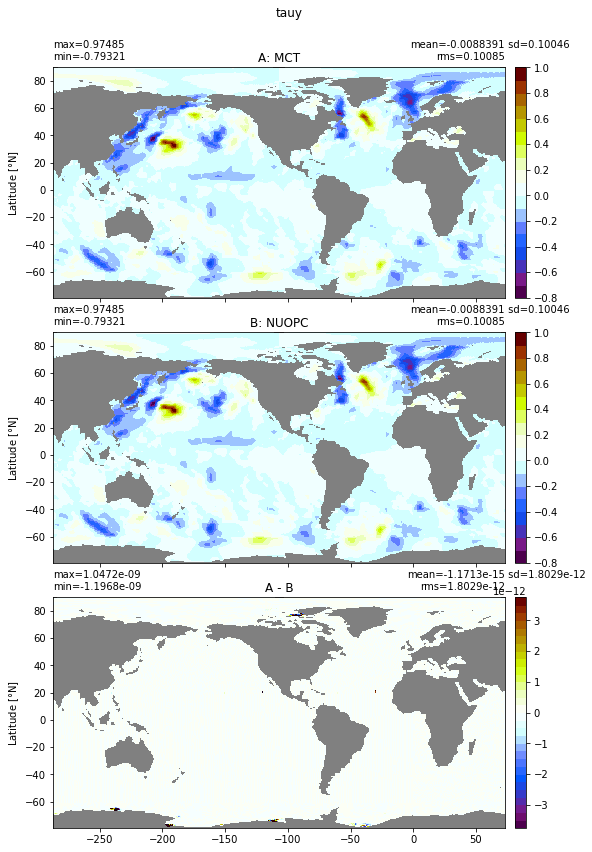

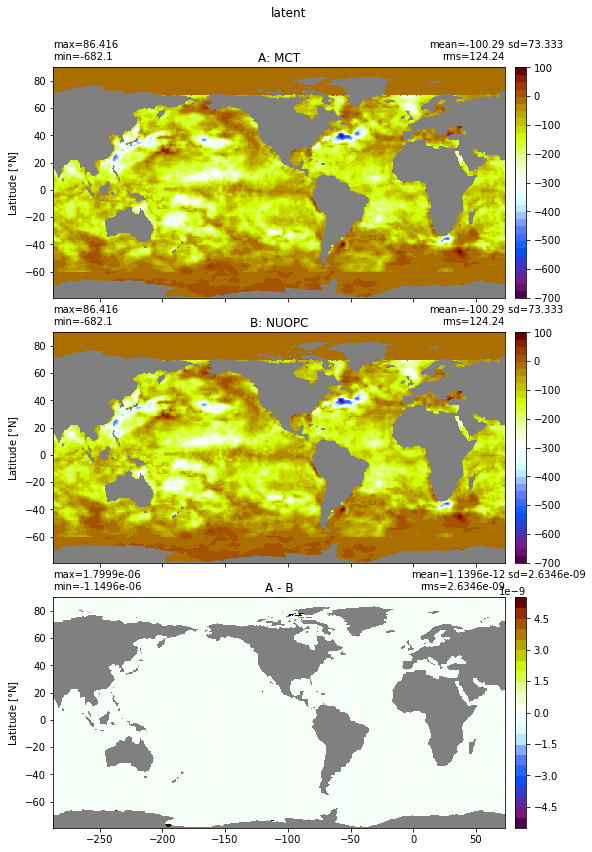

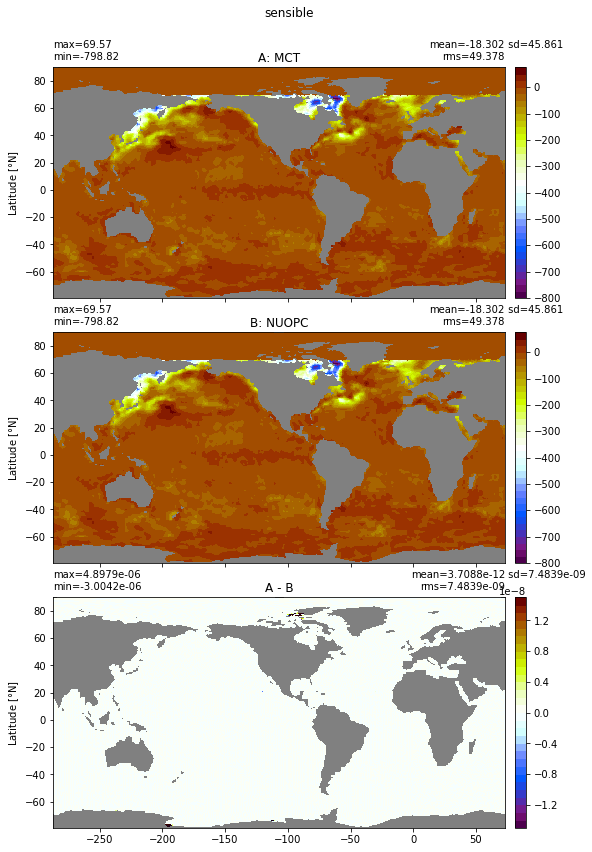

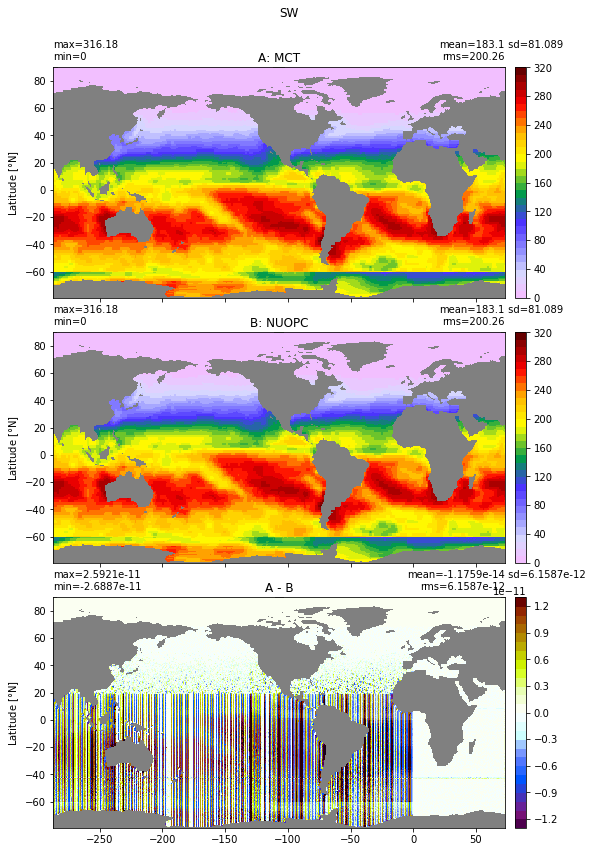

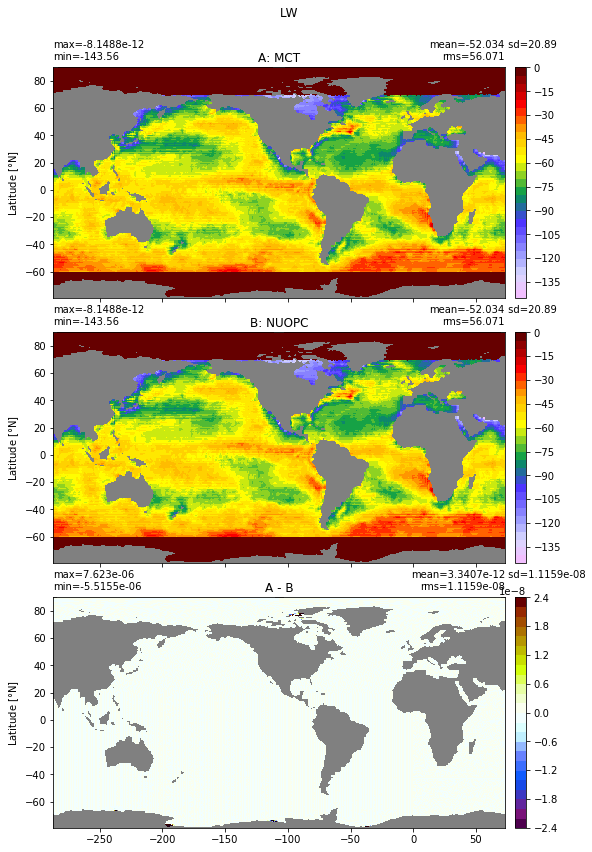

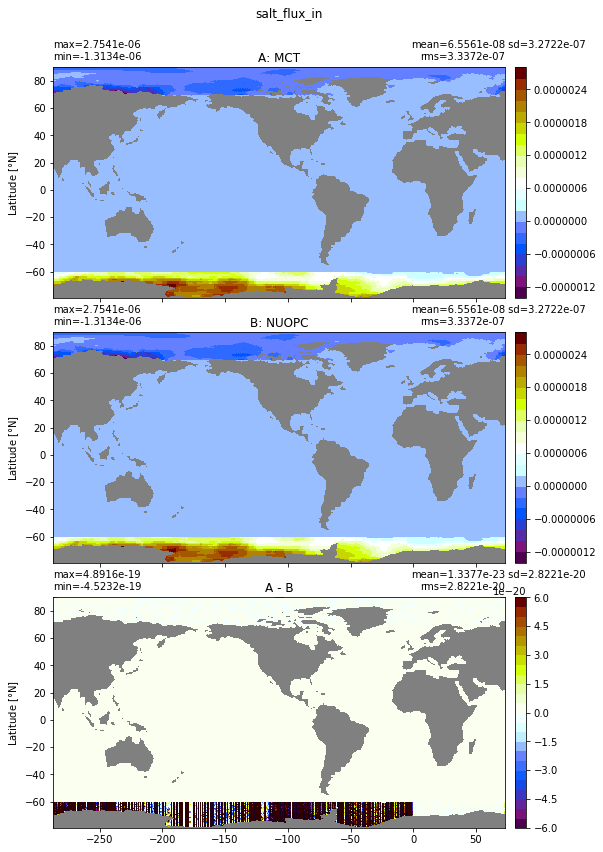

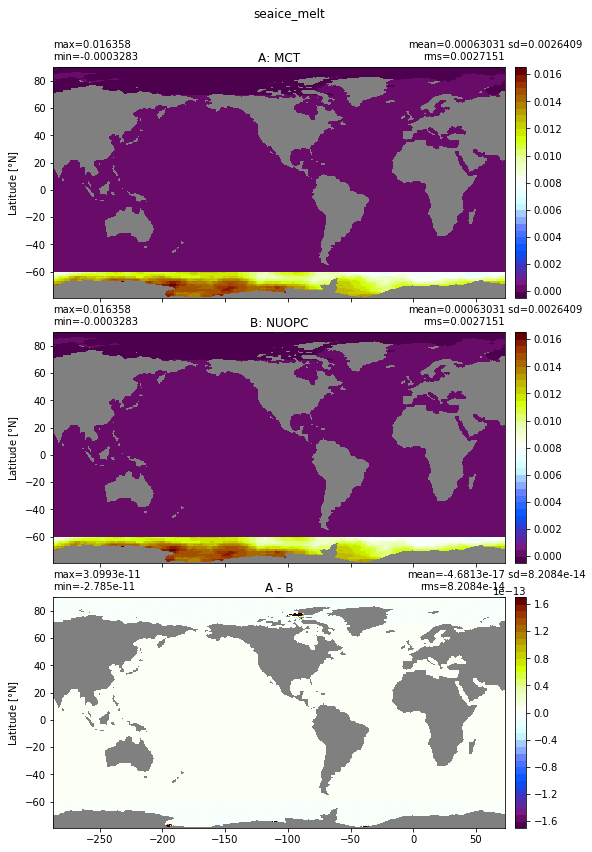

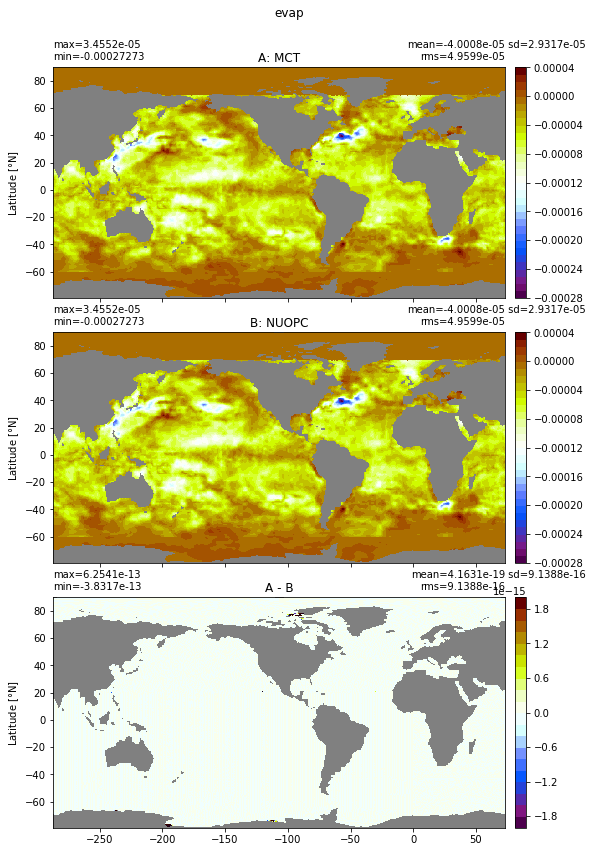

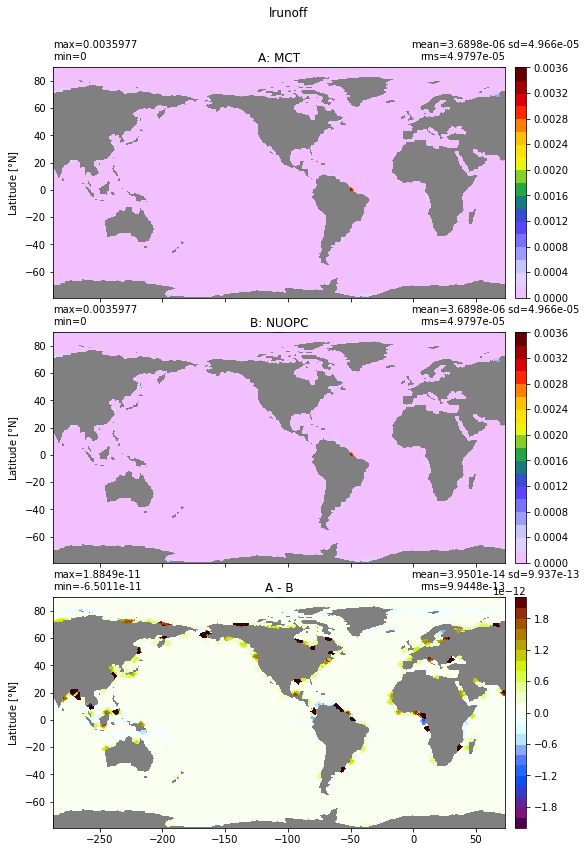

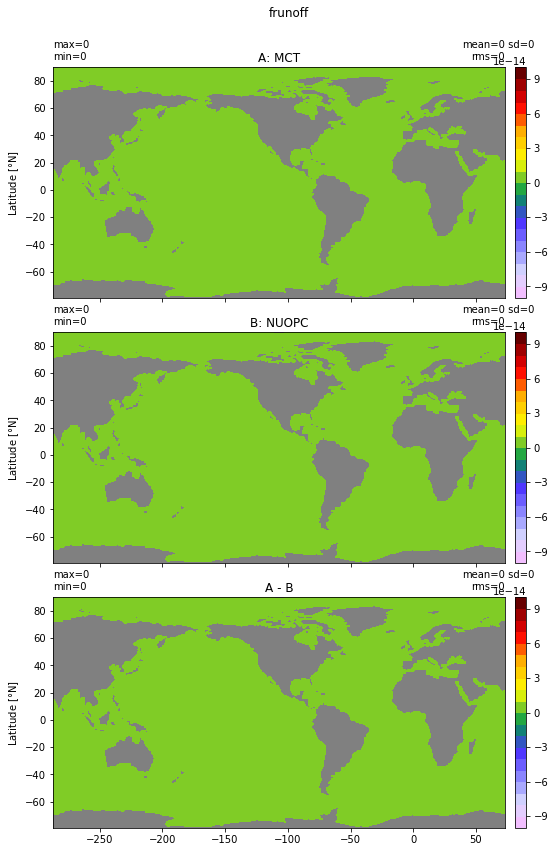

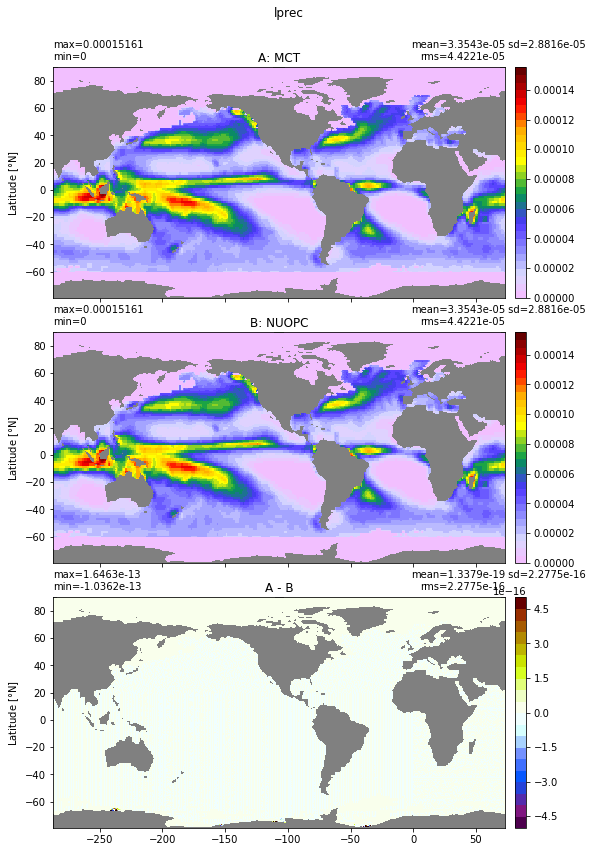

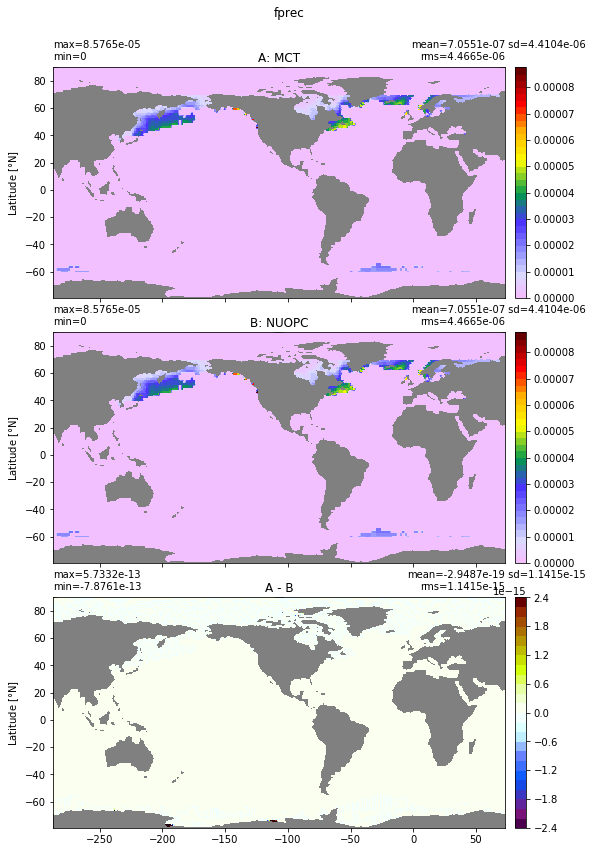

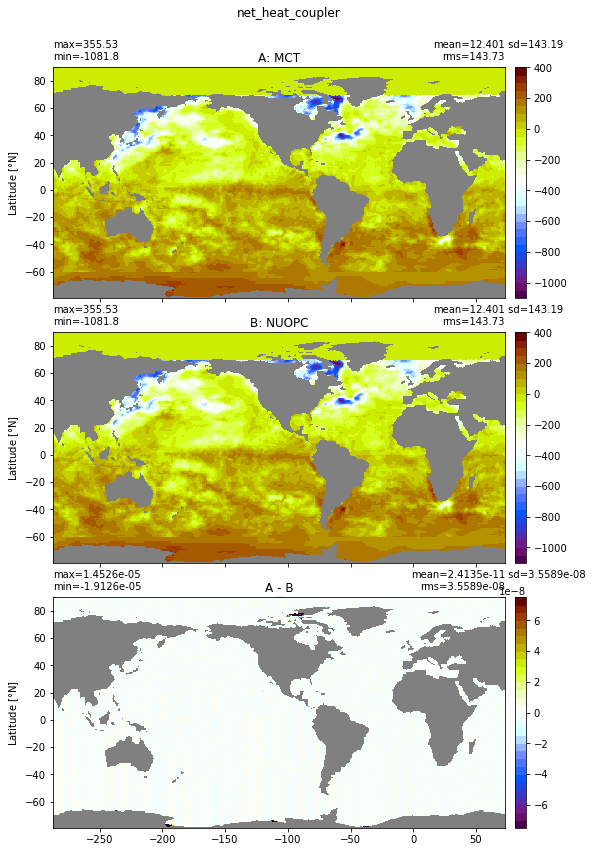

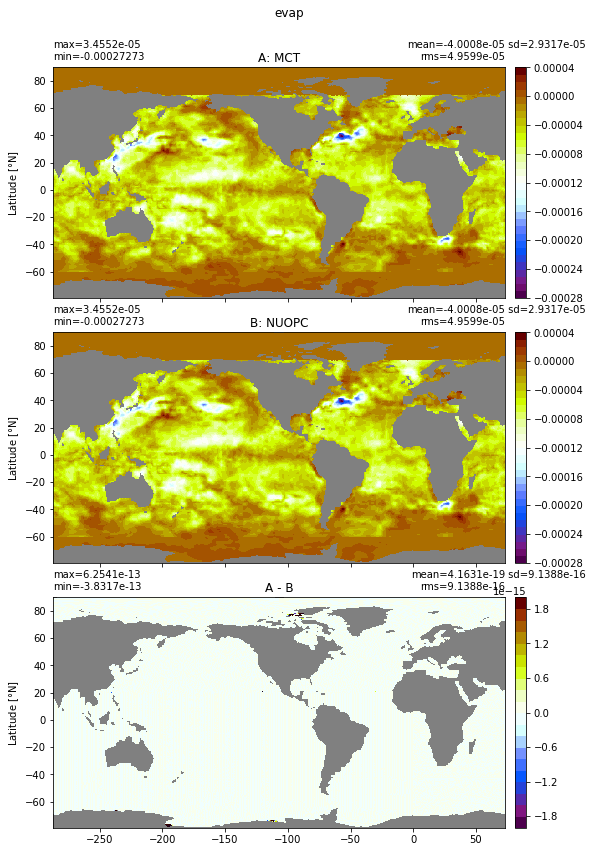

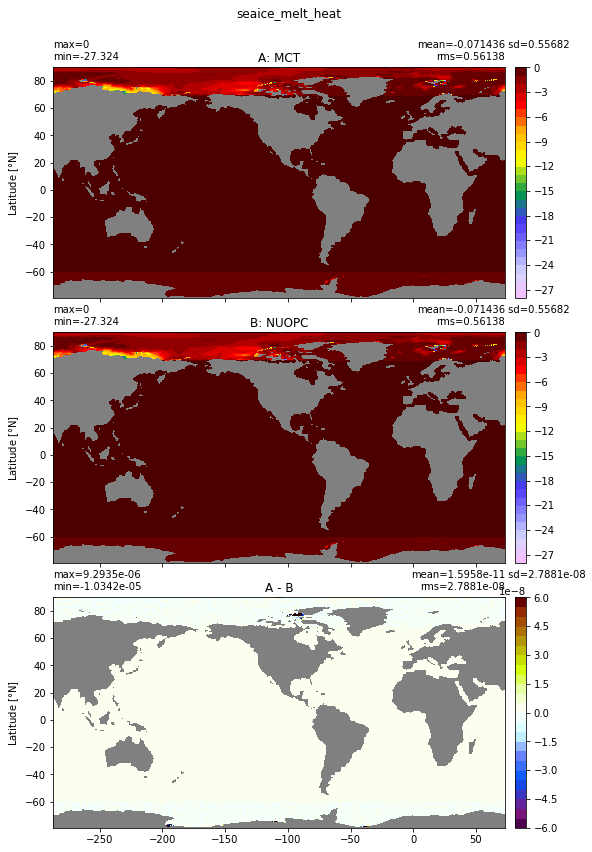

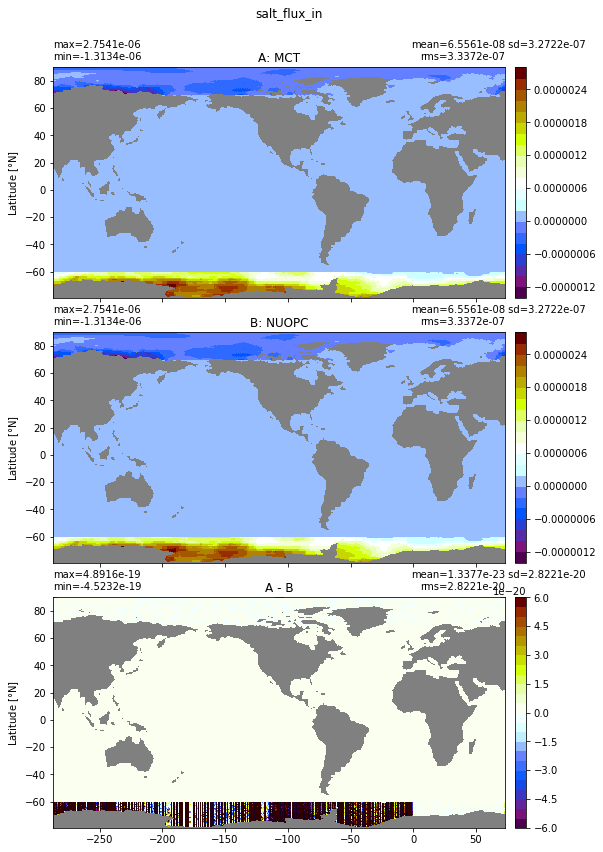

In [23]:
%matplotlib inline

t = 1 # time indice
print('MCT time (days) = ',mom_mct1['time'][t].values)
print('NUOPC time (days) = ',mom_nuopc1['time'][t].values)

for v in variables:
    #print(pairs[p])
    mct_var = np.ma.masked_invalid(mom_mct1[v][t,:].values)* grd.wet
    nuopc_var = np.ma.masked_invalid(mom_nuopc1[v][t,:].values)* grd.wet
    xycompare(mct_var, nuopc_var, x=grd.geolon, y=grd.geolat, area=grd.area_t, title1='MCT', title2='NUOPC', suptitle=v)
   